In [13]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function plot_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            #print("Plotting cell" * string(xx) * "," * string(yy) * "...")
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        # THERE WAS A BUG IN THE LEGNTH(ZEVEN). IT SHOULD BE RIGHT NOW.
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [2]:
function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

H_odf (generic function with 1 method)

In [3]:
function H_odf_RWA(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, ω, m)
    if length(zernike_coefficients_even) > m
        zernike_coefficients_even = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_even[m + 1]])
    else
        zernike_coefficients_even = []
    end
    if length(zernike_coefficients_odd) > m
        zernike_coefficients_odd = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_odd[m + 1]])
    else
        zernike_coefficients_odd = []
    end
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t) 
    p = q = 0
    if length(eventuples) > 0
        p = eventuples[length(eventuples)][2]
    end
    if length(oddtuples) > 0
        q = oddtuples[length(oddtuples)][2]
    end
    U * besselsum(p, q, -m * ϕ + ψ)
end    

function H_odf_RWA_small(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, ω, m)
    if length(zernike_coefficients_even) > m
        zernike_coefficients_even = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_even[m + 1]])
    else
        zernike_coefficients_even = []
    end
    if length(zernike_coefficients_odd) > m
        zernike_coefficients_odd = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_odd[m + 1]])
    else
        zernike_coefficients_odd = []
    end
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t) 
    p = q = 0
    if length(eventuples) > 0
        p = eventuples[length(eventuples)][2]
    end
    if length(oddtuples) > 0
        q = oddtuples[length(oddtuples)][2]
    end
    U/2 * (p * sin(m*ϕ - ψ) - q * cos(m*ϕ - ψ))
end    

H_odf_RWA_small (generic function with 1 method)

In [4]:
function besselsum(p, q, θ)
    ret = besselj(0, p)*besselj(-1, q)*cos(θ)
    i = 1
    nextterm = 1
    while i < 100
        nextterm = besselterm(i, p, q, θ)
        i += 1
        ret += nextterm
    end
    ret
end

function besselterm(n, p, q, θ)
    besselj(n, p)*besselj(-(n+1), q)*cos(n*π/2 + θ) + besselj(-n, p)*besselj(n-1, q)*cos(-n*π/2 + θ) #?
end

besselterm (generic function with 1 method)

In [5]:
Γ = 1/62
ω = 2*π*180E3
U = 2*π*10E3
θ = 0.;

In [34]:
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time = 110.0E-6
step_size = evolution_time/100
T = [0.0:step_size:evolution_time;]
zernikeeven = [[0.], [0., 1.]];
zernikeodd = [[0.], [0., 1.]];
order = 1
μ = order * ω

1.1309733552923256e6

In [35]:
function evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, μ, ω, b)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
exact_evolution_evaluator = evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, μ, ω, b)

function rwa_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, ω, b, m)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf_RWA(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, ω, m)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
rwa_evolution_evaluator = rwa_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b, order)

function rwa_small_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, ψ, ω, b, m)
    function evaluator(ρ, ϕ)
        H(t, _) = H_odf_RWA_small(ρ, ϕ, t, zernikeeven, zernikeodd, U, ψ, ω, m)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
        _, ψTARGET = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
        last(ψTARGET)
    end
end
rwa_small_evolution_evaluator = rwa_small_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b, order)


function infidelity_across_disk(F1, F2)
    function infidelity_polar(ρ, ϕ)
        ψ1 = F1(ρ, ϕ).data
        ψ2 = F2(ρ, ϕ).data
        1 - real(fidelity(ψ1, ψ2))
    end
end

infidelity_across_disk (generic function with 1 method)

In [37]:
function Z_polynomial(n::Int64)
    """Coefficients for Z_j^0, from low degree to high degree."""
    function summand(k)
        n = big(n)
        k = big(k)
        # The normalization in the front seems right, according to Wikipedia.
        (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int(n/2) - k)*factorial(Int((n)/2) - k))
    end
    res = []
    for i in Array(range(0, stop=Int(n/2), step=1))
        push!(res, summand(i))
    end
    reverse(res)
end

Z_polynomial (generic function with 1 method)

In [38]:
using Plots
discretization = 30
exact_infidelity = plot_across_unit_disk(infidelity_across_disk(exact_evolution_evaluator, rwa_small_evolution_evaluator), discretization)

([-1.0, -0.9310344827586207, -0.8620689655172413, -0.7931034482758621, -0.7241379310344828, -0.6551724137931034, -0.5862068965517241, -0.5172413793103449, -0.4482758620689655, -0.3793103448275862  …  0.3793103448275862, 0.4482758620689655, 0.5172413793103449, 0.5862068965517241, 0.6551724137931034, 0.7241379310344828, 0.7931034482758621, 0.8620689655172413, 0.9310344827586207, 1.0], [-1.0, -0.9310344827586207, -0.8620689655172413, -0.7931034482758621, -0.7241379310344828, -0.6551724137931034, -0.5862068965517241, -0.5172413793103449, -0.4482758620689655, -0.3793103448275862  …  0.3793103448275862, 0.4482758620689655, 0.5172413793103449, 0.5862068965517241, 0.6551724137931034, 0.7241379310344828, 0.7931034482758621, 0.8620689655172413, 0.9310344827586207, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

# Showing the Infidelity from Even and Odd

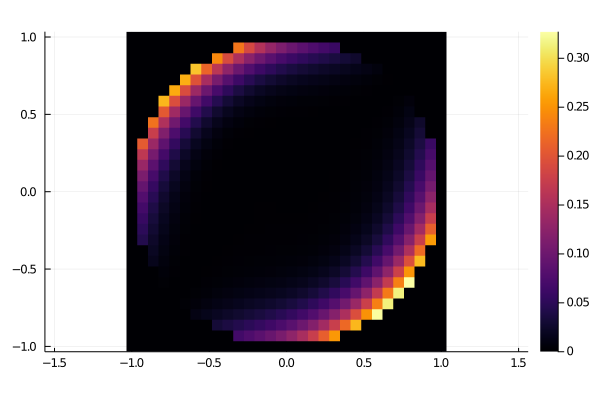

In [39]:
plot(heatmap(exact_infidelity), aspect_ratio=true)

# Infidelity from Different Orders

In [48]:
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time = 110.0E-6
step_size = evolution_time/100
T = [0.0:step_size:evolution_time;]
zernikeeven = [[0.], [0., 1.], [0., 0., 1.]];
zernikeodd = [[0.]]#[[0.], [0., 1.]];
order = 1
μ = order * ω

1.1309733552923256e6

In [49]:
function sequential_exact_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)
    """Apply all the zernike coefficients given, in order, for time T each."""
    orders = range(0, max(length(zernikeeven), length(zernikeodd)) + 1, step=1)
    function evaluator(ρ, ϕ)
        # Keep this in the definition :).
        ψ = ψ0
        for order in orders
            μ = order * ω
            H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
            _, ψ = timeevolution.master_dynamic(T, ψ, H; rates=[Γ])
            ψ = last(ψ)
        end
        ψ
    end
end

sequential_exact_evolution_evaluator_factory (generic function with 1 method)

In [50]:
sequential_evolution_evaluator = sequential_exact_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b)
rwa_small_evolution_evaluator = rwa_small_evolution_evaluator_factory(ψ0, T, zernikeeven, zernikeodd, U, θ, ω, b, order)

(::var"#evaluator#62"{Ket{SpinBasis{1//2,Int64},Array{Complex{Float64},1}},Array{Float64,1},Array{Array{Float64,1},1},Array{Array{Float64,1},1},Float64,Float64,Float64,SpinBasis{1//2,Int64},Int64}) (generic function with 1 method)

In [51]:
sequential_exact_infidelity = plot_across_unit_disk(infidelity_across_disk(sequential_evolution_evaluator, rwa_small_evolution_evaluator), discretization)

([-1.0, -0.9310344827586207, -0.8620689655172413, -0.7931034482758621, -0.7241379310344828, -0.6551724137931034, -0.5862068965517241, -0.5172413793103449, -0.4482758620689655, -0.3793103448275862  …  0.3793103448275862, 0.4482758620689655, 0.5172413793103449, 0.5862068965517241, 0.6551724137931034, 0.7241379310344828, 0.7931034482758621, 0.8620689655172413, 0.9310344827586207, 1.0], [-1.0, -0.9310344827586207, -0.8620689655172413, -0.7931034482758621, -0.7241379310344828, -0.6551724137931034, -0.5862068965517241, -0.5172413793103449, -0.4482758620689655, -0.3793103448275862  …  0.3793103448275862, 0.4482758620689655, 0.5172413793103449, 0.5862068965517241, 0.6551724137931034, 0.7241379310344828, 0.7931034482758621, 0.8620689655172413, 0.9310344827586207, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

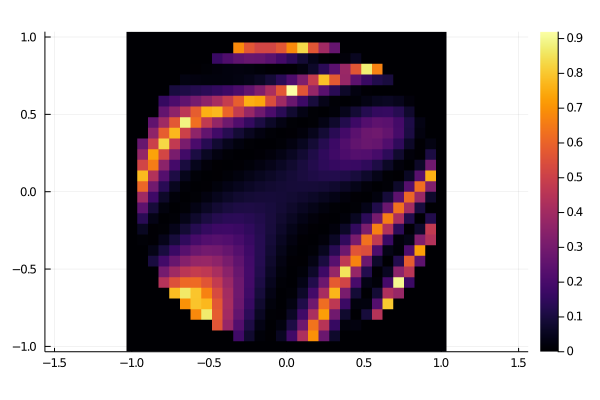

In [52]:
plot(heatmap(sequential_exact_infidelity), aspect_ratio=true)